   # Machine Learning Model


    * Getting data from the database
    * Feature engineering
        . Data analysis
    * Feature selection
        . Check for skewness
        . Remove unnecessary columns/rows
        . Feature selection
        . Address the skew by cuberroot transformer on positively skewd values
        . Address the skew by cube transformer on negatively skewed values
        . Remove null values
    * Data was split into train and test
    * Model choice
    * Hyperparameter tuning
    

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
import psycopg2
from config import db_password

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

import warnings

warnings.filterwarnings('ignore')

## Hypothesis

- Hypothesis to be tested: The emissions depend on features available in the dataset such as GDP, population metrics and fossil usage and can be predicted from these.

- Co2 emissions in the dataset is treated as dependent variable.

# Fetch data from AWS

In [2]:
user = "postgres"
password = db_password
host = "emissions-db.cr5mfnfivfxl.us-east-1.rds.amazonaws.com"
port = '5432'
database = "GHG_emissions"
conn_string = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# Create an instance of database engine
engine = create_engine(conn_string)

# Raw SQL to send to database
sql_emissions_list = """ SELECT emissions_per_capita, 
    pop_0014_percent, pop_1564_percent, pop_65up_percent, pop_growth_percent, pop_total,
    urban_pop_total, urban_pop_percent, fossil_energy_use, electricity_access_percent,
    cereal_yield, gdp_per_capita
    FROM ghg_emissions;"""

# Read the database results into Pandas dataframe
emissions_df = pd.read_sql(sql_emissions_list,engine);
emissions_df

,emissions_per_capita,pop_0014_percent,pop_1564_percent,pop_65up_percent,pop_growth_percent,pop_total,urban_pop_total,urban_pop_percent,fossil_energy_use,electricity_access_percent,cereal_yield,gdp_per_capita
0,0.762487,42.517883,54.314703,3.167414,2.081806,14452704.0,4667645.0,32.296000,NaN,42.561729,435.100000,1421.787789
1,0.878139,42.872671,54.029704,3.097626,2.136294,14154937.0,4584076.0,32.385000,NaN,33.700001,557.500000,1410.329174
2,0.871840,43.172363,53.799451,3.028186,2.191391,13855753.0,4503674.0,32.504000,NaN,32.299999,831.400000,1407.034293
3,0.905911,43.370440,53.634994,2.994566,2.163267,13555422.0,4426387.0,32.654000,29.095759,40.498375,668.500000,1408.367810
4,0.905368,43.453948,53.556956,2.989096,1.822309,13265331.0,4355539.0,32.834000,28.860873,44.000000,695.700000,1290.193956
...,...,...,...,...,...,...,...,...,...,...,...,...
7177,0.906340,45.568530,51.544417,2.887053,2.619955,344418362.0,92816300.0,26.948709,48.811618,NaN,1374.695849,697.183018
7178,0.904581,45.643524,51.460703,2.895773,2.658526,335625136.0,88973631.0,26.509823,49.280685,NaN,1427.680683,704.742868
7179,0.902599,45.607528,51.492668,2.899804,2.633682,326933522.0,85244233.0,26.073874,47.966507,NaN,949.672903,728.765774
7180,0.937815,45.580850,51.518647,2.900503,2.792410,318544083.0,81691094.0,25.645146,50.493553,NaN,1364.936487,858.297836


In [3]:
#fetch data set from Database
emissions_df.shape

(7182, 12)

In [4]:
GHG_df = emissions_df.copy()

In [5]:
GHG_df.shape

(7182, 12)

# Exploratory Data Analysis

In [6]:
#check dtypes of Data Frame
GHG_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7182 entries, 0 to 7181
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   emissions_per_capita        6430 non-null   float64
 1   pop_0014_percent            7155 non-null   float64
 2   pop_1564_percent            7155 non-null   float64
 3   pop_65up_percent            7155 non-null   float64
 4   pop_growth_percent          7153 non-null   float64
 5   pop_total                   7155 non-null   float64
 6   urban_pop_total             7101 non-null   float64
 7   urban_pop_percent           7101 non-null   float64
 8   fossil_energy_use           4723 non-null   float64
 9   electricity_access_percent  6041 non-null   float64
 10  cereal_yield                5948 non-null   float64
 11  gdp_per_capita              6687 non-null   float64
dtypes: float64(12)
memory usage: 673.4 KB


### Check for skew

In [7]:
# Check skewness on raw data
GHG_df.skew(axis = 0, skipna = True).sort_values(ascending=False)

urban_pop_total               5.266107
pop_total                     5.054372
cereal_yield                  4.327581
gdp_per_capita                3.680850
emissions_per_capita          2.740454
pop_65up_percent              1.130057
urban_pop_percent             0.122207
pop_0014_percent             -0.010011
pop_1564_percent             -0.126337
pop_growth_percent           -0.266227
fossil_energy_use            -0.787508
electricity_access_percent   -1.278649
dtype: float64

In [8]:
# Descriptive statistics
GHG_df.describe()

,emissions_per_capita,pop_0014_percent,pop_1564_percent,pop_65up_percent,pop_growth_percent,pop_total,urban_pop_total,urban_pop_percent,fossil_energy_use,electricity_access_percent,cereal_yield,gdp_per_capita
count,6430.000000,7155.000000,7155.000000,7155.000000,7153.000000,7.155000e+03,7.101000e+03,7101.000000,4723.000000,6041.000000,5948.000000,6687.000000
mean,4.212636,31.129357,61.741906,7.128736,1.489059,2.564654e+08,1.194758e+08,55.109050,65.910120,79.730564,2868.612911,10971.471653
std,5.252726,10.559871,6.947037,4.953521,1.662774,8.138013e+08,3.752095e+08,23.541963,29.004060,29.639967,2292.659189,18708.929894
min,0.000000,11.599104,46.097007,0.171770,-27.722225,9.182000e+03,3.733000e+03,5.416000,0.000000,0.533899,34.300000,22.850371
25%,0.631896,21.243883,55.403983,3.302148,0.554488,1.322634e+06,6.428460e+05,35.175000,45.438606,65.573410,1397.618511,980.249123
50%,2.403985,30.983912,63.224729,5.106476,1.420004,8.417823e+06,4.009752e+06,53.979000,75.875796,98.240425,2371.890669,3197.331024
75%,6.228607,41.144452,67.099729,10.479762,2.424812,5.547069e+07,3.165639e+07,74.127000,88.652917,100.000000,3760.575000,12807.635420
max,47.651306,51.180881,86.079246,35.041340,19.360429,7.491934e+09,4.066385e+09,100.000000,100.000000,100.000000,36761.900000,203266.913745


array([[<AxesSubplot:title={'center':'emissions_per_capita'}>,
        <AxesSubplot:title={'center':'pop_0014_percent'}>,
        <AxesSubplot:title={'center':'pop_1564_percent'}>],
       [<AxesSubplot:title={'center':'pop_65up_percent'}>,
        <AxesSubplot:title={'center':'pop_growth_percent'}>,
        <AxesSubplot:title={'center':'pop_total'}>],
       [<AxesSubplot:title={'center':'urban_pop_total'}>,
        <AxesSubplot:title={'center':'urban_pop_percent'}>,
        <AxesSubplot:title={'center':'fossil_energy_use'}>],
       [<AxesSubplot:title={'center':'electricity_access_percent'}>,
        <AxesSubplot:title={'center':'cereal_yield'}>,
        <AxesSubplot:title={'center':'gdp_per_capita'}>]], dtype=object)

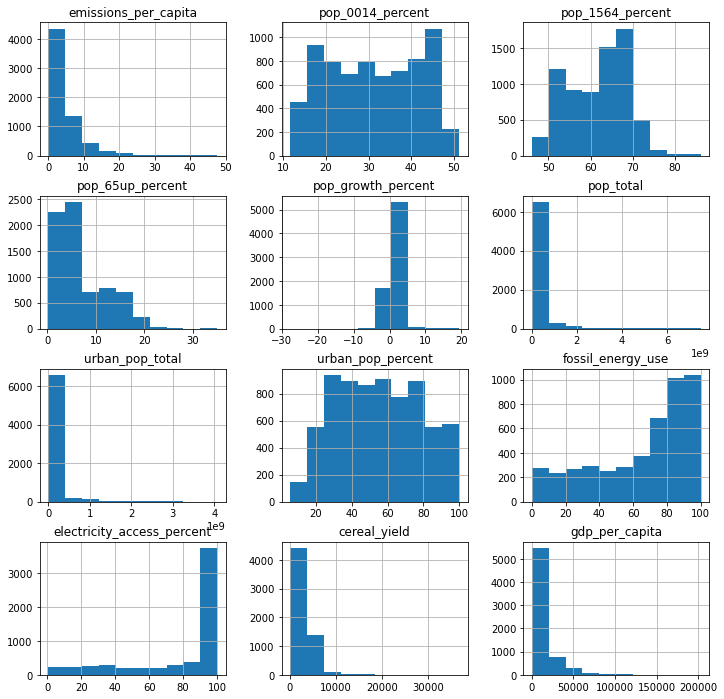

In [9]:
# Plot histograms
GHG_df.hist(figsize=(12, 12))

# Addressing Skewness



In [10]:
skew_df=GHG_df.copy()

In [11]:
#check skewness before handling
skew_df.skew(axis = 0, skipna = True).sort_values(ascending=False)

urban_pop_total               5.266107
pop_total                     5.054372
cereal_yield                  4.327581
gdp_per_capita                3.680850
emissions_per_capita          2.740454
pop_65up_percent              1.130057
urban_pop_percent             0.122207
pop_0014_percent             -0.010011
pop_1564_percent             -0.126337
pop_growth_percent           -0.266227
fossil_energy_use            -0.787508
electricity_access_percent   -1.278649
dtype: float64

In [12]:
# Skewness reduction using cuberoot transformation for positively skewed values
# and adding the newly skewed columns to dataframe

skew_df['urban_pop_total_cbrt'] = np.cbrt(skew_df['urban_pop_total'])
skew_df['pop_total_cbrt'] = np.cbrt(skew_df['pop_total'])
skew_df['cereal_yield_cbrt'] = np.cbrt(skew_df['cereal_yield'])
skew_df['gdp_per_capita_cbrt'] = np.cbrt(skew_df['gdp_per_capita'])
skew_df['emissions_per_capita_cbrt'] = np.cbrt(skew_df['emissions_per_capita'])

In [13]:
# Skewness reduction using cube transformation for negatively skewed values 
# and adding the newly skewed columns to dataframe

skew_df['electricity_access_percent_cube'] = np.power(skew_df['electricity_access_percent'],3)

In [14]:
# Check for new columns added to skew_df
skew_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7182 entries, 0 to 7181
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   emissions_per_capita             6430 non-null   float64
 1   pop_0014_percent                 7155 non-null   float64
 2   pop_1564_percent                 7155 non-null   float64
 3   pop_65up_percent                 7155 non-null   float64
 4   pop_growth_percent               7153 non-null   float64
 5   pop_total                        7155 non-null   float64
 6   urban_pop_total                  7101 non-null   float64
 7   urban_pop_percent                7101 non-null   float64
 8   fossil_energy_use                4723 non-null   float64
 9   electricity_access_percent       6041 non-null   float64
 10  cereal_yield                     5948 non-null   float64
 11  gdp_per_capita                   6687 non-null   float64
 12  urban_pop_total_cbrt

In [15]:
#columns to be dropped from data frame after reducing and adding newly skewed columns

drop_columns = ['urban_pop_total',
'pop_total',
'cereal_yield',           
'gdp_per_capita',                                         
'emissions_per_capita',                 
'electricity_access_percent']

In [16]:
#drop the unskewed columns
skew_df.drop(columns = drop_columns, axis = 1, inplace = True)

In [17]:
#final check for the skewed data
skew_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7182 entries, 0 to 7181
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pop_0014_percent                 7155 non-null   float64
 1   pop_1564_percent                 7155 non-null   float64
 2   pop_65up_percent                 7155 non-null   float64
 3   pop_growth_percent               7153 non-null   float64
 4   urban_pop_percent                7101 non-null   float64
 5   fossil_energy_use                4723 non-null   float64
 6   urban_pop_total_cbrt             7101 non-null   float64
 7   pop_total_cbrt                   7155 non-null   float64
 8   cereal_yield_cbrt                5948 non-null   float64
 9   gdp_per_capita_cbrt              6687 non-null   float64
 10  emissions_per_capita_cbrt        6430 non-null   float64
 11  electricity_access_percent_cube  6041 non-null   float64
dtypes: float64(12)
memor

In [18]:
#check for the skewness after reducing
skew_df.skew().sort_values(ascending=False)

pop_total_cbrt                     1.989828
urban_pop_total_cbrt               1.931646
pop_65up_percent                   1.130057
gdp_per_capita_cbrt                1.009301
cereal_yield_cbrt                  0.596332
emissions_per_capita_cbrt          0.362554
urban_pop_percent                  0.122207
pop_0014_percent                  -0.010011
pop_1564_percent                  -0.126337
pop_growth_percent                -0.266227
electricity_access_percent_cube   -0.768246
fossil_energy_use                 -0.787508
dtype: float64

In [19]:
#check for the shape of the dataframe
skew_df.shape

(7182, 12)

# Correlation Plot

In [20]:
# Function to plot correlation matrix
# Input parameters: dataframe
# Output: correlation dataframe
def plot_corr(df):
    corr = df.corr().abs()
    sns.set(font_scale=2)
    f,ax=plt.subplots(figsize=(30,20))
    sns.heatmap(corr, annot=True, cmap='Blues', fmt = ".2f", center=0, vmin=-1, vmax=1)
    plt.title('Correlation between features', fontsize=25, weight='bold' )
    plt.show()
    sns.set(font_scale=1)
    return corr
    

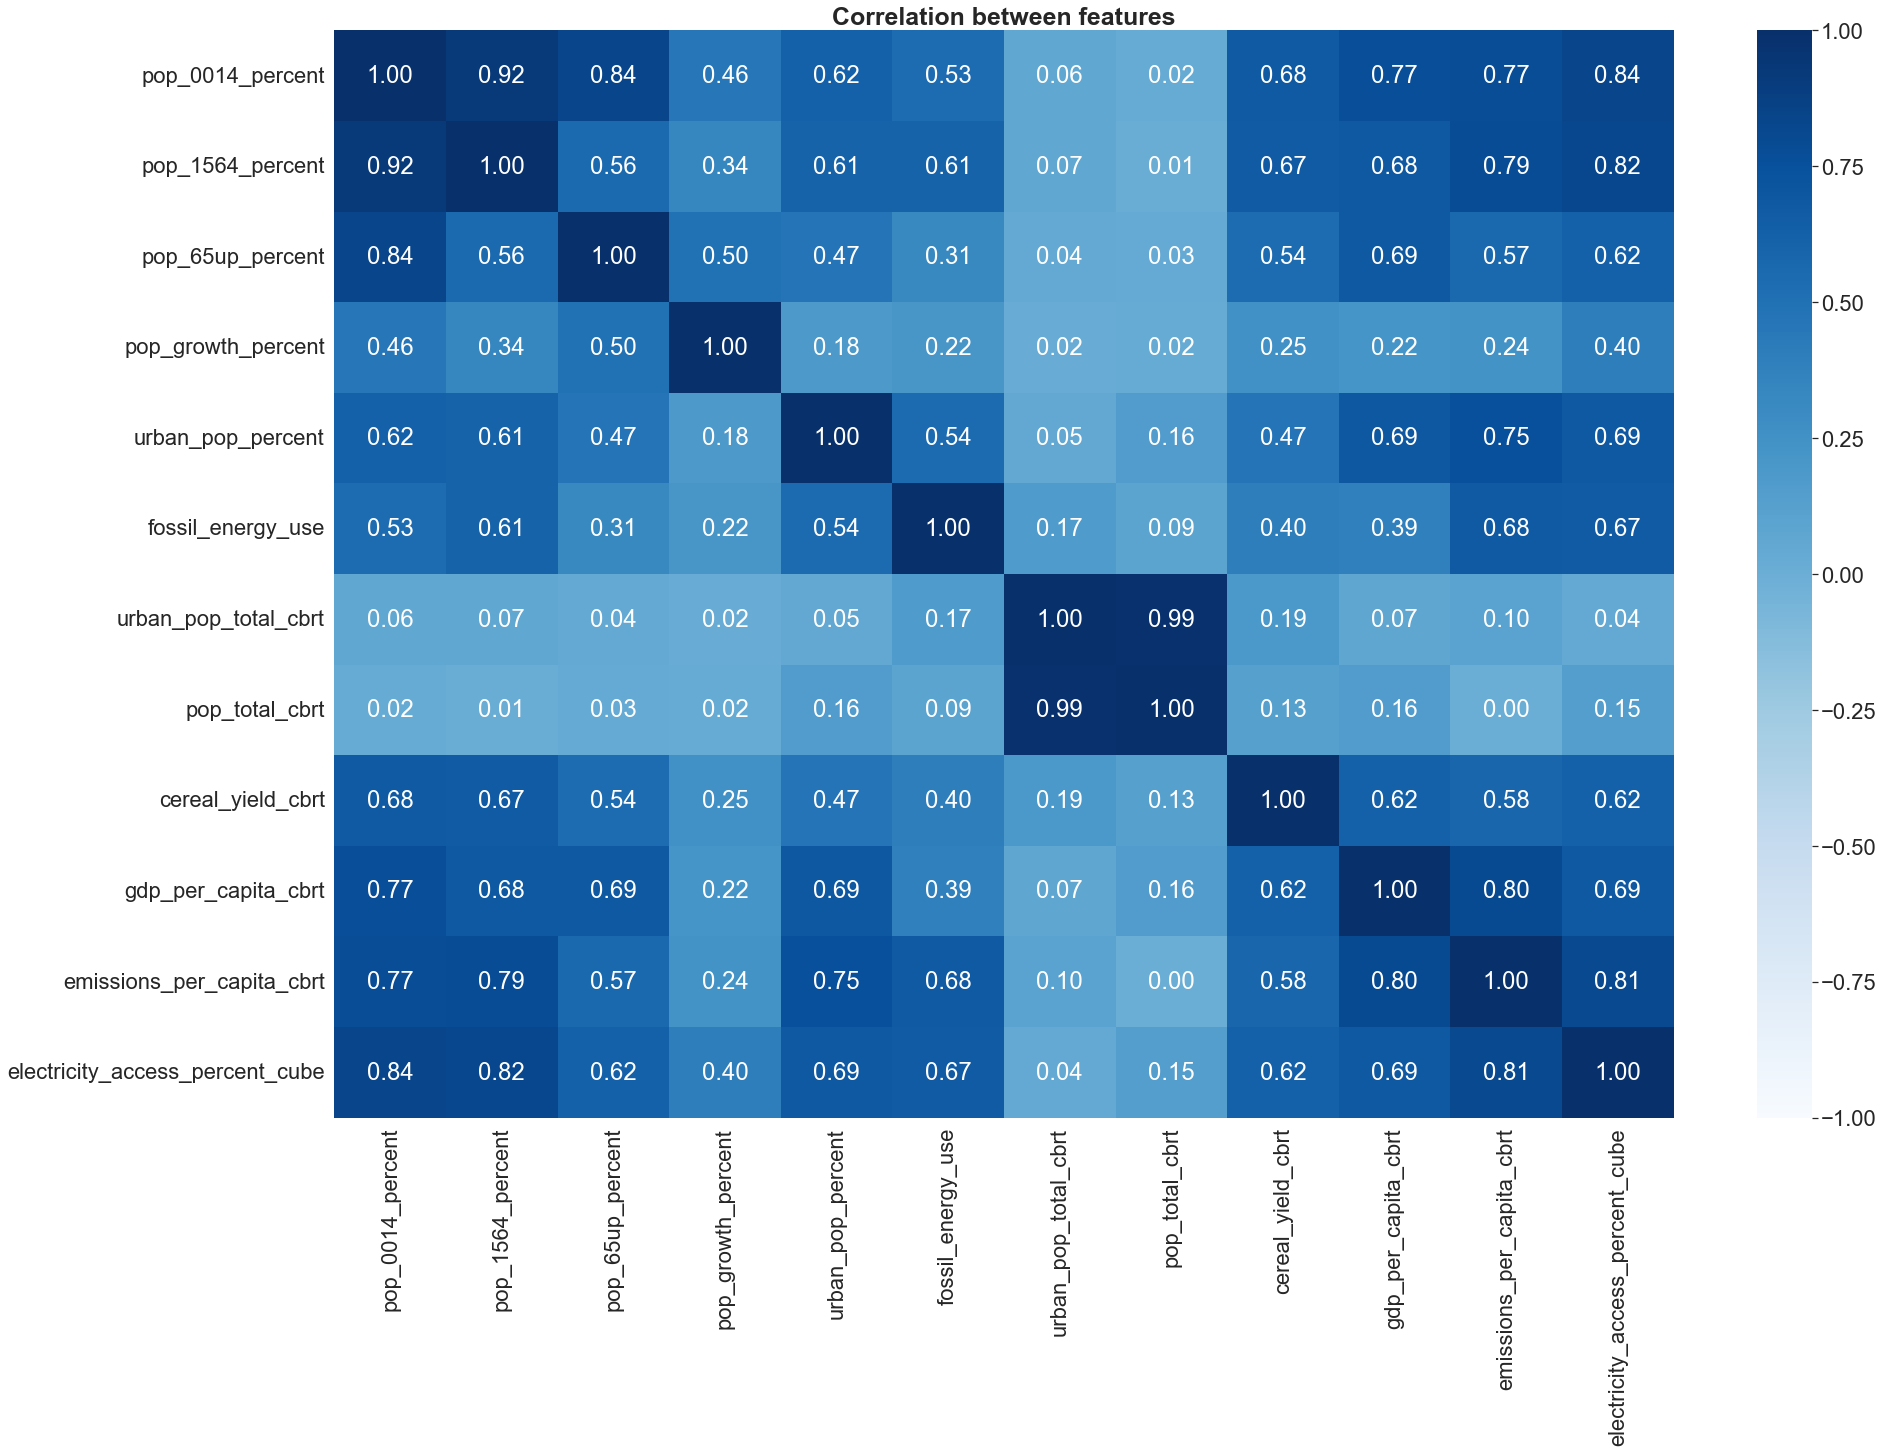

Top 10 correlations for emissions_per_capita:
emissions_per_capita_cbrt          1.000000
electricity_access_percent_cube    0.806102
gdp_per_capita_cbrt                0.797550
pop_1564_percent                   0.786996
pop_0014_percent                   0.774496
urban_pop_percent                  0.750215
fossil_energy_use                  0.679379
cereal_yield_cbrt                  0.578703
pop_65up_percent                   0.569241
pop_growth_percent                 0.240964
Name: emissions_per_capita_cbrt, dtype: float64
Bottom 5 correlations for emissions_per_capita:
cereal_yield_cbrt       0.578703
pop_65up_percent        0.569241
pop_growth_percent      0.240964
urban_pop_total_cbrt    0.104666
pop_total_cbrt          0.003297
Name: emissions_per_capita_cbrt, dtype: float64


In [21]:
# Plot correlation 
correlation = plot_corr(skew_df)
print("Top 10 correlations for emissions_per_capita:")
print(correlation['emissions_per_capita_cbrt'].sort_values(ascending=False)[:10]) #top 10 correlations
print("Bottom 5 correlations for emissions_per_capita:")
print(correlation['emissions_per_capita_cbrt'].sort_values(ascending=False)[-5:]) #least 5 correlations

.Dependent Variables:     
        
        .emissions_per_capita_cbrt

.Independent Variables:

        .cereal_yield_cbrt
        .electricity_access_percent_cube
        .gdp_per_capita_cbrt
        .pop_growth_percent
        .pop_total_cbrt
        .urban_pop_total_cbrt
        .urban_pop_percent
        .pop_0014_percent
        .pop_1564_percent
        .pop_65up_percent
        .fossil_energy_use
        
- Choosing features that have good correlation with emissions_per_capita_cbrt (correlation coefficient > 0.5)

# Feature Selection

In [22]:
#select features for analysis.
selected_features = ['emissions_per_capita_cbrt',
                     'fossil_energy_use',
                     'pop_1564_percent',
                     'cereal_yield_cbrt',
                     'gdp_per_capita_cbrt',
                     'urban_pop_percent',
                     'electricity_access_percent_cube',
                     'pop_0014_percent' ]
ftr_df = pd.DataFrame(skew_df, columns = selected_features)
ftr_df

,emissions_per_capita_cbrt,fossil_energy_use,pop_1564_percent,cereal_yield_cbrt,gdp_per_capita_cbrt,urban_pop_percent,electricity_access_percent_cube,pop_0014_percent
0,0.913575,NaN,54.314703,7.577565,11.244624,32.296000,77100.607432,42.517883
1,0.957608,NaN,54.029704,8.230287,11.214334,32.385000,38272.755599,42.872671
2,0.955313,NaN,53.799451,9.403077,11.205594,32.504000,33698.264612,43.172363
3,0.967598,29.095759,53.634994,8.743805,11.209133,32.654000,66422.128802,43.370440
4,0.967405,28.860873,53.556956,8.860822,10.886418,32.834000,85184.000000,43.453948
...,...,...,...,...,...,...,...,...
7177,0.967751,48.811618,51.544417,11.119080,8.867113,26.948709,NaN,45.568530
7178,0.967125,49.280685,51.460703,11.260138,8.899048,26.509823,NaN,45.643524
7179,0.966418,47.966507,51.492668,9.829347,8.999036,26.073874,NaN,45.607528
7180,0.978827,50.493553,51.518647,11.092705,9.503407,25.645146,NaN,45.580850


In [23]:
# Check for the statistics
ftr_df.describe()

,emissions_per_capita_cbrt,fossil_energy_use,pop_1564_percent,cereal_yield_cbrt,gdp_per_capita_cbrt,urban_pop_percent,electricity_access_percent_cube,pop_0014_percent
count,6430.000000,4723.000000,7155.000000,5948.000000,6687.000000,7101.000000,6041.000000,7155.000000
mean,1.363663,65.910120,61.741906,13.482311,17.451932,55.109050,683667.081873,31.129357
std,0.623288,29.004060,6.947037,3.142651,9.552493,23.541963,395137.834194,10.559871
min,0.000000,0.000000,46.097007,3.249112,2.837687,5.416000,0.152187,11.599104
25%,0.858121,45.438606,55.403983,11.180543,9.933725,35.175000,281957.276538,21.243883
50%,1.339606,75.875796,63.224729,13.336183,14.732028,53.979000,948136.136608,30.983912
75%,1.839912,88.652917,67.099729,15.550753,23.396792,74.127000,1000000.000000,41.144452
max,3.625420,100.000000,86.079246,33.250587,58.797054,100.000000,1000000.000000,51.180881


In [24]:
#check for null values
ftr_df.isna().sum()

emissions_per_capita_cbrt           752
fossil_energy_use                  2459
pop_1564_percent                     27
cereal_yield_cbrt                  1234
gdp_per_capita_cbrt                 495
urban_pop_percent                    81
electricity_access_percent_cube    1141
pop_0014_percent                     27
dtype: int64

In [25]:
#drop null values
ftr_df.dropna(inplace=True)

In [26]:
#check null values
ftr_df.isna().sum()

emissions_per_capita_cbrt          0
fossil_energy_use                  0
pop_1564_percent                   0
cereal_yield_cbrt                  0
gdp_per_capita_cbrt                0
urban_pop_percent                  0
electricity_access_percent_cube    0
pop_0014_percent                   0
dtype: int64

In [27]:
#check data shape after droping null values
ftr_df.shape

(3743, 8)

In [28]:
#check skew after droping null values
ftr_df.skew().sort_values(ascending=False)

gdp_per_capita_cbrt                0.792002
cereal_yield_cbrt                  0.264114
emissions_per_capita_cbrt          0.232625
pop_0014_percent                   0.219467
urban_pop_percent                 -0.177689
pop_1564_percent                  -0.410951
electricity_access_percent_cube   -0.797289
fossil_energy_use                 -0.861310
dtype: float64

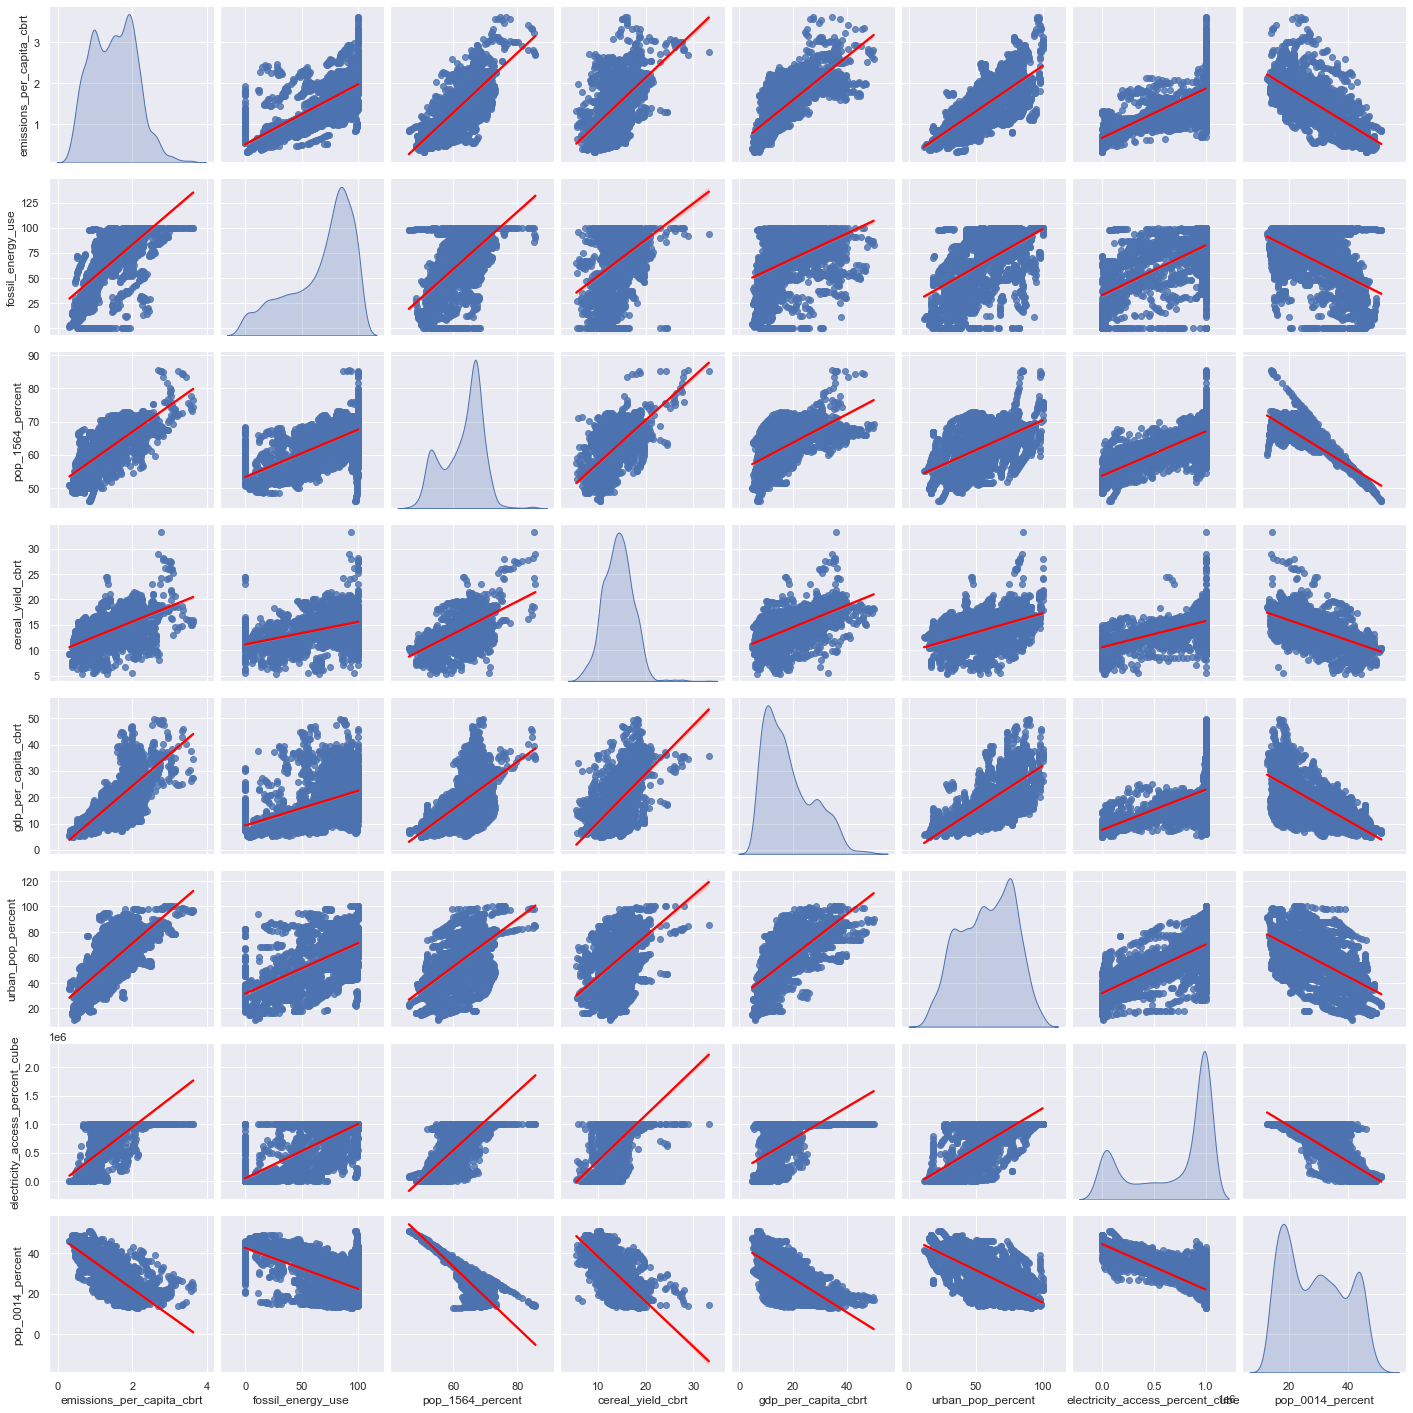

In [29]:
#plot after dropping null values
sns.pairplot(ftr_df, diag_kind='kde', kind='reg', plot_kws={'line_kws':{'color':'red'}})

In [30]:
ftr_df.head()

,emissions_per_capita_cbrt,fossil_energy_use,pop_1564_percent,cereal_yield_cbrt,gdp_per_capita_cbrt,urban_pop_percent,electricity_access_percent_cube,pop_0014_percent
3,0.967598,29.095759,53.634994,8.743805,11.209133,32.654,66422.128802,43.370440
4,0.967405,28.860873,53.556956,8.860822,10.886418,32.834,85184.000000,43.453948
5,0.956813,28.492743,53.647926,8.374868,10.268132,33.015,50243.415233,43.383758
6,0.907621,24.855705,53.889596,9.018071,9.788353,33.196,58332.301318,43.170055
7,0.848652,23.930831,54.169175,7.676693,9.134994,33.378,81571.928633,42.912761


In [31]:
#Check frequency count
col_names = [
'cereal_yield_cbrt',
'gdp_per_capita_cbrt',
'emissions_per_capita_cbrt',
'electricity_access_percent_cube']
for col in col_names:
    print(skew_df[col].value_counts())   

11.856390    20
10.000000    15
14.422496     6
11.696071     6
12.599210     5
             ..
16.713658     1
16.797600     1
16.896487     1
16.892283     1
11.140915     1
Name: cereal_yield_cbrt, Length: 5580, dtype: int64
8.611900     2
11.272144    2
7.460149     2
8.479072     2
8.574033     2
            ..
15.876886    1
16.494080    1
17.511793    1
17.711169    1
9.349040     1
Name: gdp_per_capita_cbrt, Length: 6640, dtype: int64
0.881045    2
0.920314    2
0.891388    2
0.891568    2
0.920061    2
           ..
1.612114    1
1.592356    1
1.602238    1
1.612270    1
0.994010    1
Name: emissions_per_capita_cbrt, Length: 6377, dtype: int64
1000000.000000    2299
994012.083187       16
970299.000000       16
997003.044685       16
991026.881996       13
                  ... 
58365.115258         1
53157.369528         1
39698.369524         1
33652.055982         1
7949.621993          1
Name: electricity_access_percent_cube, Length: 3449, dtype: int64


In [32]:
ml_df = ftr_df.copy()

In [33]:
ml_df.shape

(3743, 8)

In [34]:
ml_df['emissions_per_capita_cbrt'].value_counts()

0.938446    2
0.934163    2
0.920314    2
0.930420    2
0.911732    2
           ..
1.867459    1
1.864288    1
1.870858    1
1.802778    1
0.960549    1
Name: emissions_per_capita_cbrt, Length: 3703, dtype: int64

## Model Choice
    
Since features exhibit both linear and non-linear relationship with CO2 emissions per capita, Machine Learning algorithms that can handle non-linearities like DecisionTreeRegressor and RandomForestRegressor will be trained and used.
    
### Decision Tree 
 Decision Tree algorithm belongs to the family of supervised learning algorithms. Unlike other supervised learning algorithms, the decision tree algorithm can be used for solving regression and classification problems too.
#### Advantages :
    .Interpretability
    .Less Data Preparation
    .Non-Parametric 
    .Versatile
    .Non-Linearity

#### Disadvantages :
    .Overfitting
    .Feature Reduction & Data Resampling 
    .Optimization
 
### Random Forest
 A Random Forest Regression model is powerful and accurate. It usually performs great on many problems, including features with non-linear relationships. Disadvantages, however, include the following: there is no interpretability, overfitting may easily occur, we must choose the number of trees to include in the model.

#### Declare feature vector and target variable

In [35]:
X = ml_df.drop(['emissions_per_capita_cbrt'], axis=1)
y = ml_df['emissions_per_capita_cbrt']

### Split data into  train and test set

In [36]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [37]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2507, 7)
(1236, 7)
(2507,)
(1236,)


### Decision Tree Regressor

In [38]:
# To control randomness
random_state = 42

In [39]:
# create the model
reg_decision_model=DecisionTreeRegressor(random_state = random_state)

In [40]:
# fit independent variables to the dependent variables
reg_decision_model.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [41]:
reg_predictions = reg_decision_model.predict(X_test)

In [42]:
r1 = reg_decision_model.score(X_train,y_train)

In [43]:
# Decision Tree Regressor metrics
mse = mean_squared_error(y_test, reg_predictions)
rmse = mean_squared_error(y_test, reg_predictions, squared=False)
r2 = reg_decision_model.score(X_test,y_test)

print(f' Decision Tree MSE: {mse}')
print(f' Decision Tree RMSE: {rmse}')
print(f' Decision Tree R-squared: {r2}')

 Decision Tree MSE: 0.02079805498856733
 Decision Tree RMSE: 0.14421530774701877
 Decision Tree R-squared: 0.9437618328885612


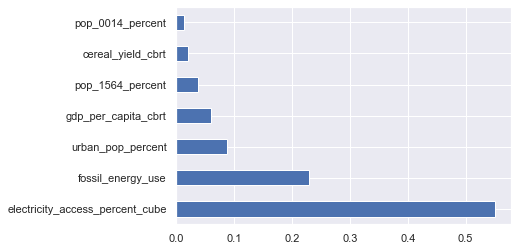

In [44]:
feat_importances = pd.Series(reg_decision_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh')
plt.show()

### The feature importance chart shows that emissions per capita is largely impacted by energy factors followed by population numbers and GDP.

## Decision Tree Model Evaluation


In [45]:
# predicting the test set results
prediction=reg_decision_model.predict(X_test)

<AxesSubplot:xlabel='emissions_per_capita_cbrt', ylabel='Density'>

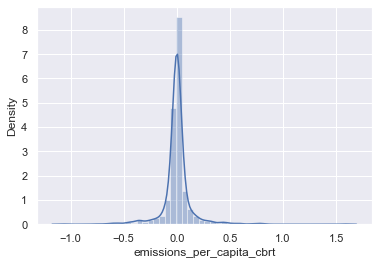

In [46]:
# Plotting errors
sns.distplot(y_test-prediction)

Text(0.5, 1.0, 'True vs. Pred Value for CO2 emissions per capita, DT model')

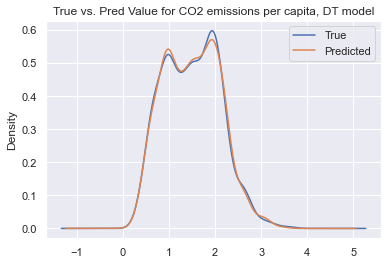

In [47]:
# plot distributions of true and predicted values
y_test.plot.density(label='True')
pd.Series(prediction).plot.density(label='Predicted')
plt.legend()
plt.title('True vs. Pred Value for CO2 emissions per capita, DT model')

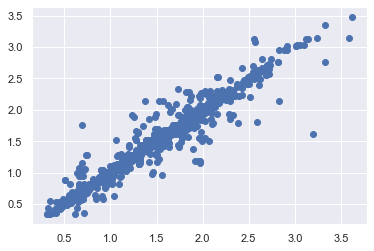

In [48]:
#checking predicted y and labeled y using a scatter plot.
plt.scatter(y_test,prediction)

## Hyper Parameter Tuning using Grid search

In [49]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best","random"],
            "max_depth" : range(1,11),
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [50]:
# Initialize search grid
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [51]:
# function for calculating how much time take for hyperparameter tuning

def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        #print(thour,":",tmin,':',round(tsec,2))

In [52]:
%%capture
from datetime import datetime

start_time=timer(None)

tuning_model.fit(X,y)

timer(start_time)


In [53]:
# best hyperparameters 
tuning_model.best_params_

{'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

#max_depth: or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

#splitter: or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

In [54]:
# best model score
tuning_model.best_score_

-0.09437118266359679

 ## Training Decision Tree With Best Hyperparameters

In [55]:
# applying the best parameters to tune the model
tuned_hyper_model= DecisionTreeRegressor(max_depth=4,max_features='auto',max_leaf_nodes=10,min_samples_leaf=1,min_weight_fraction_leaf=0.1,splitter='best', random_state = random_state)

In [56]:
# fitting model
tuned_hyper_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=4, max_features='auto', max_leaf_nodes=10,
                      min_weight_fraction_leaf=0.1, random_state=42)

In [57]:
# prediction 
tuned_pred=tuned_hyper_model.predict(X_test)

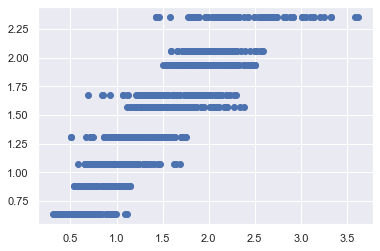

In [58]:
plt.scatter(y_test,tuned_pred)

#### Decision Tree Regressor with hyper parameters

In [59]:
# Decision Tree Regression metrics with hyper parameters
print('MAE:', mean_absolute_error(y_test, tuned_pred))
print('MSE:', mean_squared_error(y_test, tuned_pred))
print('RMSE:',mean_squared_error(y_test, tuned_pred, squared=False))
print('R-squared:',tuned_hyper_model.score(X_test,y_test))

MAE: 0.19931196591742448
MSE: 0.06791026292776069
RMSE: 0.2605959764228156
R-squared: 0.8163699097241288


#### Decision Tree Regressor without hyper parameters

In [60]:
# Decision Tree Regression metrics 
print('Decision Tree MSE:', mean_squared_error(y_test,prediction))
print('Decision Tree RMSE:', mean_squared_error(y_test,prediction, squared=False))
print('Decision Tree R-squared:',reg_decision_model.score(X_test,y_test))

Decision Tree MSE: 0.02079805498856733
Decision Tree RMSE: 0.14421530774701877
Decision Tree R-squared: 0.9437618328885612


## Conclusion on Decision tree Regressor

- RMSE: 0.207 is observed with HyperParameter Tuning
- RMSE: 0.144 is observed without HyperParameter Tuning.

To conclude,the Decision Tree model is already good at predicting values for emissions_per_capita, there was not much improvement in the model after HyperParameter Tuning.

## Using non-linear regressors with Default Hyperparameters

- Using 3-Fold Cross-Validation


In [61]:
# Instantiate RandomForestRegressor
rf = RandomForestRegressor(random_state = random_state)

In [62]:
# Fit train values
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [63]:
#calculate r2 on train and test sets
r1 = rf.score(X_train, y_train)
r2 = rf.score(X_test,y_test)

In [64]:
# Random Forest Regressor: mse and rmse
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [65]:
#print results
print(f'RMSE of Random Forest training set:{rmse}')
print(f'MSE of Random Forest training set:{mse}')
print(f'R1 of Random Forest training set:{r1}')
print(f'R2 of Random Forest testing set:{r2}')

RMSE of Random Forest training set:0.09330131524458928
MSE of Random Forest training set:0.008705135426370228
R1 of Random Forest training set:0.9965836694193158
R2 of Random Forest testing set:0.9764612190368269


## Machine learning algorithms used for cross validaton

Random forest (RF), support vector machine (SVM), k-nearest neighbor (KNN)

HPT algorithms used: Grid search, Random search

Performance metric: Mean square error (MSE)

In [66]:
#Random Forest
clf = RandomForestRegressor(random_state = random_state)
scores = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_squared_error') # 3-fold cross-validation
print("MSE:"+ str(-scores.mean()))

MSE:0.05209939484651239


In [67]:
#Support Vector Machine
clf = SVR()
scores = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_squared_error')
print("MSE:"+ str(-scores.mean()))

MSE:0.13108587789798898


In [68]:
#KNN
clf = KNeighborsRegressor()
scores = cross_val_score(clf, X, y, cv=3,scoring='neg_mean_squared_error')
print("MSE:"+ str(-scores.mean()))

MSE:0.09495475048943336


- Since RandomForestRegressor performs better than other algorithms, determine hyper parameters for RandomForest

## Random Forest Regressor:  Hyper-Parameter Tuning

Algorithm 1: Grid Search

Search all the given hyper-parameter configurations

Advantages:
Simple implementation.

Disadvantages:
Time-consuming,
Only efficient with categorical HPs.

### Algorithm 1: GridSearchCV

In [69]:
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': [100, 580, 930],
    'max_depth': [180,220,630,750]
}
clf = RandomForestRegressor(random_state=random_state)
grid = GridSearchCV(clf, rf_params, cv=3, scoring='neg_mean_squared_error')
grid.fit(X, y)
print(grid.best_params_)
print("MSE:"+ str(-grid.best_score_))

{'max_depth': 180, 'n_estimators': 930}
MSE:0.051846065744878024


### Algorithm 2: Random Search

Randomly search hyper-parameter combinations in the search space

Advantages:
More efficient than GS.
Enable parallelization.

Disadvantages:
Not consider previous results.
Not efficient with conditional HPs.

In [70]:
# Define the hyperparameter configuration space
rf_params = {
    'n_estimators': sp_randint(100,300),
    "max_features":sp_randint(1,13),
    'max_depth': sp_randint(1,50),
    "min_samples_split":sp_randint(2,20),
    "min_samples_leaf":sp_randint(1,11),
    "criterion":['mse','mae']
}
n_iter_search=20 #number of iterations is set to 20, you can increase this number if time permits
clf = RandomForestRegressor(random_state = random_state)
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='neg_mean_squared_error',random_state=random_state)
Random.fit(X, y)
print(Random.best_params_)
print("MSE:"+ str(-Random.best_score_))

{'criterion': 'mae', 'max_depth': 35, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 140}
MSE:0.04604408932365316


In [71]:
# Rebuild RandomForest Regressor with best params from Randomized Search CV
rf_best = RandomForestRegressor(n_estimators=140, 
                                max_depth=35,
                                min_samples_split=6, 
                                random_state=random_state)

#Fit (train) the model
rf_best.fit(X, y)

RandomForestRegressor(max_depth=35, min_samples_split=6, n_estimators=140,
                      random_state=42)

In [72]:
rf_best_prediction = rf_best.predict(X_test)

In [73]:
# Random Forest Regressor metrics
rf_mse = mean_squared_error(y_test, rf_best_prediction)
rf_rmse = mean_squared_error(y_test, rf_best_prediction, squared=False)
rf_r2 = rf_best.score(X_test,y_test)
print(f"Random Forest Regressor MSE: {rf_mse}")
print(f"Random Forest Regressor RMSE: {rf_rmse}")
print(f"Random Forest Regressor R-squared: {rf_r2}")

Random Forest Regressor MSE: 0.0012631939713373308
Random Forest Regressor RMSE: 0.03554144019784976
Random Forest Regressor R-squared: 0.9965843097494799
